## [Bayesian Regression - Introduction](http://pyro.ai/examples/bayesian_regression.html#Bayesian-Regression---Introduction-(Part-1))

In [6]:
import os

In [7]:
import numpy as np
import pandas as pd

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import torch
import pyro

In [3]:
from functools import partial

In [4]:
import pyro.distributions as dist

In [8]:
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])

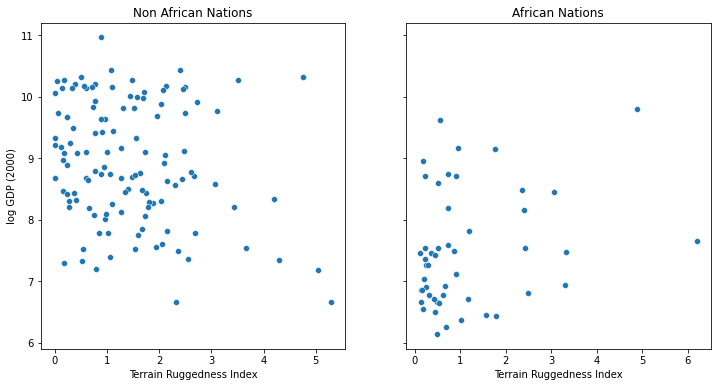

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = df[df["cont_africa"] == 1]
non_african_nations = df[df["cont_africa"] == 0]
sns.scatterplot(x=non_african_nations["rugged"],
                y=non_african_nations["rgdppc_2000"],
                ax=ax[0])
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
sns.scatterplot(x=african_nations["rugged"],
                y=african_nations["rgdppc_2000"],
                ax=ax[1])
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [10]:
from torch import nn
from pyro.nn import PyroModule

In [11]:
assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [12]:
df["cont_africa_x_rugged"] = df["cont_africa"] * df["rugged"]

data = torch.tensor(df[["cont_africa", "rugged", "cont_africa_x_rugged", "rgdppc_2000"]].values,
                        dtype=torch.float)
x_data, y_data = data[:, :-1], data[:, -1]

In [13]:
x_data.shape

torch.Size([170, 3])

In [14]:
y_data.shape

torch.Size([170])

In [15]:
lr_model = PyroModule[nn.Linear](3,1)

In [16]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(lr_model.parameters(), lr=0.05)
num_iterations = 1500

In [17]:
def train():
    y_pred = lr_model(x_data).squeeze(-1)
    loss = loss_fn(y_pred, y_data)
    optim.zero_grad()
    loss.backward()
    optim.step()
    return loss

In [18]:
for j in range(num_iterations):
    loss = train()
    if (j+1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j+1, loss.item()))

[iteration 0050] loss: 3143.2749
[iteration 0100] loss: 1562.6621
[iteration 0150] loss: 1033.0021
[iteration 0200] loss: 771.4789
[iteration 0250] loss: 598.3004
[iteration 0300] loss: 469.1989
[iteration 0350] loss: 370.9480
[iteration 0400] loss: 297.9760
[iteration 0450] loss: 245.7177
[iteration 0500] loss: 209.6713
[iteration 0550] loss: 185.6992
[iteration 0600] loss: 170.3129
[iteration 0650] loss: 160.7755
[iteration 0700] loss: 155.0633
[iteration 0750] loss: 151.7568
[iteration 0800] loss: 149.9067
[iteration 0850] loss: 148.9061
[iteration 0900] loss: 148.3832
[iteration 0950] loss: 148.1191
[iteration 1000] loss: 147.9903
[iteration 1050] loss: 147.9297
[iteration 1100] loss: 147.9021
[iteration 1150] loss: 147.8900
[iteration 1200] loss: 147.8849
[iteration 1250] loss: 147.8828
[iteration 1300] loss: 147.8820
[iteration 1350] loss: 147.8817
[iteration 1400] loss: 147.8816
[iteration 1450] loss: 147.8815
[iteration 1500] loss: 147.8815


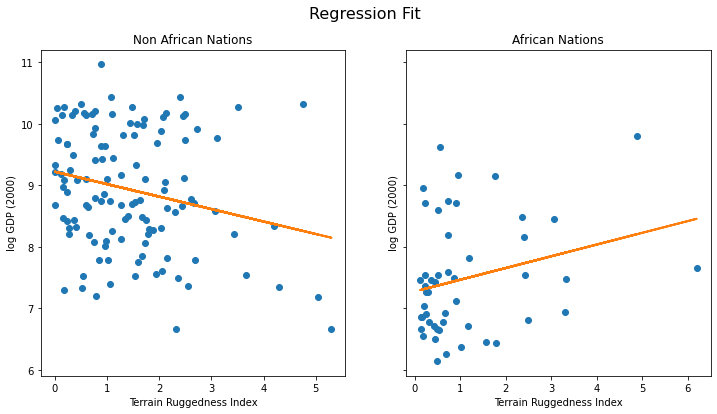

In [19]:
fit = df.copy()
fit["mean"] = lr_model(x_data).detach().cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
african_nations = fit[fit["cont_africa"] == 1]
non_african_nations = fit[fit["cont_africa"] == 0]
fig.suptitle("Regression Fit", fontsize=16)
ax[0].plot(non_african_nations["rugged"], non_african_nations["rgdppc_2000"], "o")
ax[0].plot(non_african_nations["rugged"], non_african_nations["mean"], linewidth=2)
ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
ax[1].plot(african_nations["rugged"], african_nations["rgdppc_2000"], "o")
ax[1].plot(african_nations["rugged"], african_nations["mean"], linewidth=2)
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

### Bayesian Regression Model

In [20]:
from pyro.nn import PyroSample

In [21]:
class BR(PyroModule):
    def __init__(self, in_features, out_target):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_target)
        # The BayesianRegression module internally uses the same PyroModule[nn.Linear] module. 
        # However, note that we replace the weight and the bias of the this module with PyroSample statements. 
        # These statements allow us to place a prior over the weight and bias parameters, 
        # instead of treating them as fixed learnable parameters. For the bias component, 
        # we set a reasonably wide prior since it is likely to be substantially above 0.
        self.linear.weight = PyroSample(dist.Normal(0.0,1.).expand([out_target, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_target]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0.,10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            # we use the obs argument to the pyro.sample statement to condition on the observed data y_data 
            # with a learned observation noise sigma
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

 Gaussian with diagonal covariance, i.e. it assumes that there is no correlation amongst the latent variables (quite a strong modeling assumption as we shall see i

In [22]:
from pyro.infer.autoguide import AutoDiagonalNormal

In [23]:
model = BR(3,1)
guide = AutoDiagonalNormal(model)

In [24]:
from pyro.infer import SVI, Trace_ELBO

In [25]:
adam = pyro.optim.Adam({"lr":0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [26]:
pyro.clear_param_store()

for j in range(1000):
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j+1, loss / (len(data))))

[iteration 0001] loss: 3.9607
[iteration 0101] loss: 2.8370
[iteration 0201] loss: 2.0953
[iteration 0301] loss: 1.4712
[iteration 0401] loss: 1.5028
[iteration 0501] loss: 1.4647
[iteration 0601] loss: 1.4583
[iteration 0701] loss: 1.4655
[iteration 0801] loss: 1.4612
[iteration 0901] loss: 1.4608


In [27]:
guide.requires_grad_(False)

AutoDiagonalNormal()

In [28]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-2.2792, -1.8437, -0.1536,  0.3529,  9.1879])
AutoDiagonalNormal.scale tensor([0.0570, 0.1419, 0.0389, 0.0782, 0.0737])


In [29]:
guide.quantiles([0.25, 0.5, 0.75])

{'sigma': tensor([0.8967, 0.9286, 0.9615]),
 'linear.weight': tensor([[[-1.9394, -0.1799,  0.3002]],
 
         [[-1.8437, -0.1536,  0.3529]],
 
         [[-1.7480, -0.1274,  0.4057]]]),
 'linear.bias': tensor([[9.1382],
         [9.1879],
         [9.2376]])}

### Model Evaluation

In [30]:
from pyro.infer import Predictive

In [31]:
preds =  Predictive(model, guide=guide, num_samples=800, return_sites=("linear.weight", 'obs',"_RETURN"))
samples = preds(x_data)

In [32]:
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v,0),
            "std": torch.std(v,0),
            "5%": v.kthvalue(int(len(v)*0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v)*0.95), dim=0)[0],            
        }
    return site_stats

In [33]:
pred_summary = summary(samples)

In [34]:
mu = pred_summary['_RETURN']
y = pred_summary["obs"]

predictions = pd.DataFrame({
    "cont_africa": x_data[:, 0],
    "rugged": x_data[:, 1],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_gdp": y_data,
})

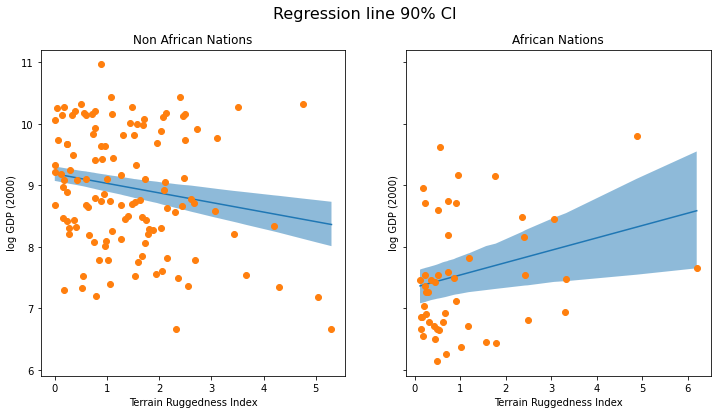

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)

african_nations = predictions[predictions["cont_africa"] == 1]
non_african_nations = predictions[predictions["cont_africa"] == 0]
african_nations = african_nations.sort_values(by=["rugged"])
non_african_nations = non_african_nations.sort_values(by=["rugged"])

fig.suptitle("Regression line 90% CI", fontsize=16)

ax[0].plot(non_african_nations["rugged"],
           non_african_nations["mu_mean"])

ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["mu_perc_5"],
                   non_african_nations["mu_perc_95"],
                   alpha=0.5) 

ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")     

ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])
ax[1].plot(african_nations["rugged"],
           african_nations["mu_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["mu_perc_5"],
                   african_nations["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");     

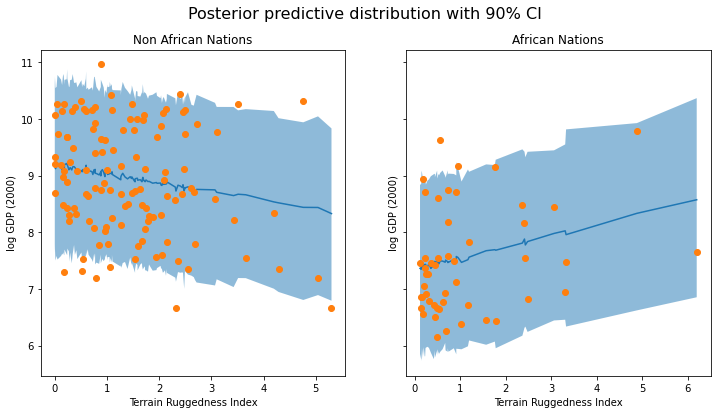

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(non_african_nations["rugged"],
           non_african_nations["y_mean"])

ax[0].fill_between(non_african_nations["rugged"],
                   non_african_nations["y_perc_5"],
                   non_african_nations["y_perc_95"],
                   alpha=0.5)

ax[0].plot(non_african_nations["rugged"],
           non_african_nations["true_gdp"],
           "o")

ax[0].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="Non African Nations")
idx = np.argsort(african_nations["rugged"])

ax[1].plot(african_nations["rugged"],
           african_nations["y_mean"])
ax[1].fill_between(african_nations["rugged"],
                   african_nations["y_perc_5"],
                   african_nations["y_perc_95"],
                   alpha=0.5)
ax[1].plot(african_nations["rugged"],
           african_nations["true_gdp"],
           "o")
ax[1].set(xlabel="Terrain Ruggedness Index",
          ylabel="log GDP (2000)",
          title="African Nations");

In [37]:
weight = samples["linear.weight"]
weight = weight.reshape(weight.shape[0], 3)

In [38]:
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]

/home/dulunche/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dulunche/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


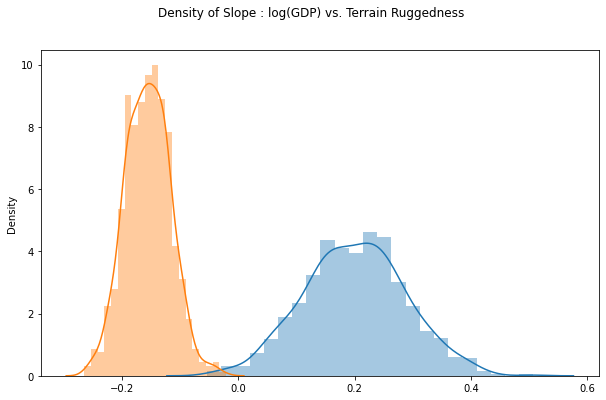

In [39]:
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Density of Slope : log(GDP) vs. Terrain Ruggedness");

## Model Serving via TorchScript

Finally, note that the model, guide and the Predictive utility class are all torch.nn.Module instances, and can be serialized as TorchScript.

In [40]:
from collections import defaultdict
from pyro import poutine
from pyro.poutine.util import prune_subsample_sites
import warnings

In [41]:
class Predict(torch.nn.Module):
    def __init__(self, model, guide) -> None:
        super().__init__()
        self.model = model
        self.guide = guide

    def forward(self, *args, **kwargs):
        samples = {}
        guide_trace = poutine.trace(self.guide).get_trace(*args, **kwargs)
        model_trace = poutine.trace(poutine.replay(self.model, guide_trace)).get_trace(*args, **kwargs)
        for site in prune_subsample_sites(model_trace).stochastic_nodes:
            samples[site] = model_trace.nodes[site]['value']
        return tuple(v for _, v in sorted(samples.items()))

In [42]:
predict_fn = Predict(model, guide)

In [43]:
predict_module = torch.jit.trace_module(predict_fn, {"forward": (x_data,)}, check_trace=False)

In [44]:
torch.jit.save(predict_module, '/tmp/reg_predict.pt')
pred_loaded = torch.jit.load('/tmp/reg_predict.pt')

In [45]:
pred_loaded(x_data)[1]

tensor([[-1.8655, -0.2099,  0.2971]])

In [46]:
weight = []
for _ in range(800):
    # index = 1 corresponds to "linear.weight"
    weight.append(pred_loaded(x_data)[1])

In [47]:
weight = torch.stack(weight).detach()

In [48]:
weight.shape

torch.Size([800, 1, 3])

In [49]:
weight = weight.reshape(weight.shape[0], 3)

/home/dulunche/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/dulunche/.local/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


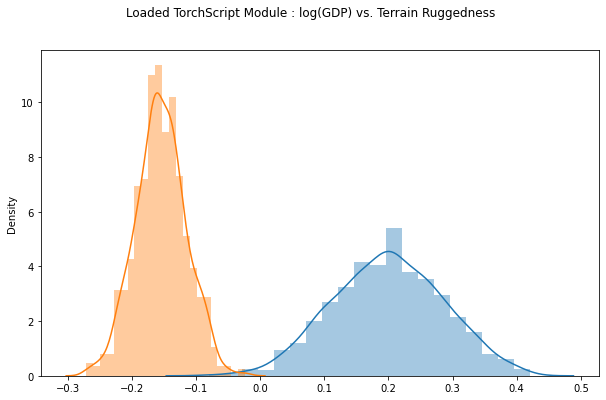

In [50]:
gamma_within_africa = weight[:, 1] + weight[:, 2]
gamma_outside_africa = weight[:, 1]
fig = plt.figure(figsize=(10, 6))
sns.distplot(gamma_within_africa, kde_kws={"label": "African nations"},)
sns.distplot(gamma_outside_africa, kde_kws={"label": "Non-African nations"})
fig.suptitle("Loaded TorchScript Module : log(GDP) vs. Terrain Ruggedness");

___

## [Bayesian Regression - Inference Algorithms](http://pyro.ai/examples/bayesian_regression_ii.html#Bayesian-Regression---Inference-Algorithms-(Part-2))

In [51]:
import logging
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.8.2')

In [52]:
%matplotlib inline
plt.style.use('ggplot')

logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

We will write out the model again, similar to that in Part I, but explicitly without the use of PyroModule. We will write out each term in the regression, using the same priors. bA and bR are regression coefficients corresponding to is_cont_africa and ruggedness, a is the intercept, and bAR is the correlating factor between the two features.

In [53]:
def model(is_cont_africa, ruggedness, log_gdp):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR",  dist.Normal(0., 1.))

    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

In [54]:
def guide(is_cont_africa, ruggedness, log_gdp):
    a_loc = pyro.param("a_loc", torch.tensor(0.))
    a_scale = pyro.param("a_scale", torch.tensor(1.), constraint=constraints.positive)

    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.))

    weights_loc = pyro.param('weight_loc', torch.randn(3))
    weights_scale = pyro.param('weight_scale', torch.ones(3), constraint=constraints.positive)

    a = pyro.sample('a', dist.Normal(a_loc, a_scale))
    b_a = pyro.sample('bA', dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample('bR', dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample('bAR', dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample('sigma', dist.Normal(sigma_loc, torch.tensor(0.05)))

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

In [55]:
from pyro.infer import SVI, Trace_ELBO

In [56]:
svi = SVI(
            model,
            guide,
            optim.Adam({'lr':.05}),
            loss = Trace_ELBO()
        )

In [57]:
df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)

In [58]:
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

In [59]:
for i in range(5000):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 100 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 5795.468078792095
Elbo loss: 765.3544555306435
Elbo loss: 478.94802314043045
Elbo loss: 438.79995185136795
Elbo loss: 395.10364723205566
Elbo loss: 383.55809420347214
Elbo loss: 383.7115207910538
Elbo loss: 346.4596281051636
Elbo loss: 329.44677233695984
Elbo loss: 308.3229989409447
Elbo loss: 278.3793386220932
Elbo loss: 257.51196855306625
Elbo loss: 247.2570869922638
Elbo loss: 254.12206554412842
Elbo loss: 258.38778030872345
Elbo loss: 247.19688880443573
Elbo loss: 251.17446702718735
Elbo loss: 252.87407511472702
Elbo loss: 248.24607491493225
Elbo loss: 248.60587882995605
Elbo loss: 249.442092359066
Elbo loss: 247.52902030944824
Elbo loss: 248.79963678121567
Elbo loss: 247.34876209497452
Elbo loss: 247.63936799764633
Elbo loss: 251.22494000196457
Elbo loss: 248.85719817876816
Elbo loss: 249.31609004735947
Elbo loss: 249.82198518514633
Elbo loss: 247.7418533563614
Elbo loss: 249.40030306577682
Elbo loss: 247.0044640302658
Elbo loss: 248.3618168234825
Elbo loss: 247.6332483

In [60]:
from pyro.infer import Predictive

In [61]:
number_samples = 1000

In [62]:
predictive = Predictive(model, guide=guide, num_samples= number_samples)

In [63]:
svi_samples = {
                k: v.reshape(number_samples).detach().cpu().numpy() 
                        for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
                        if k != "obs"
}

In [64]:
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

In [65]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%       75%       95%
0  9.177156  0.060809  9.076248  9.139858  9.178367  9.218038  9.273558 

Site: bA
       mean       std        5%       25%       50%       75%       95%
0 -1.891609  0.123241 -2.090178 -1.980407 -1.888452 -1.804362 -1.701167 

Site: bR
     mean       std        5%       25%       50%       75%       95%
0 -0.1574  0.039531 -0.222782 -0.183221 -0.157425 -0.132659 -0.091277 

Site: bAR
       mean       std        5%      25%       50%       75%       95%
0  0.304455  0.067509  0.194806  0.25952  0.304847  0.348758  0.414783 

Site: sigma
       mean       std       5%       25%       50%       75%       95%
0  0.900512  0.047971  0.82178  0.867931  0.899595  0.932784  0.979191 



___

### HMC

In [66]:
from pyro.infer import MCMC, NUTS

In [67]:
nuts_kernel = NUTS(model)

In [68]:
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)

In [69]:
mcmc.run(is_cont_africa, ruggedness, log_gdp)

Sample: 100%|██████████| 1200/1200 [00:24, 48.69it/s, step size=4.73e-01, acc. prob=0.920]


In [70]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [71]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean      std        5%       25%       50%       75%       95%
0  9.179541  0.13631  8.948674  9.092796  9.182643  9.272237  9.384867 

Site: bA
       mean      std     5%       25%       50%       75%       95%
0 -1.832929  0.23524 -2.217 -1.983383 -1.837151 -1.681208 -1.441309 

Site: bAR
       mean       std        5%       25%       50%       75%      95%
0  0.342208  0.129034  0.126836  0.251245  0.343096  0.428025  0.55039 

Site: bR
       mean       std        5%       25%      50%       75%       95%
0 -0.182088  0.074199 -0.295771 -0.232334 -0.18379 -0.134868 -0.055269 

Site: sigma
       mean       std        5%       25%      50%       75%       95%
0  0.954808  0.054706  0.871808  0.916038  0.94973  0.989015  1.049073 



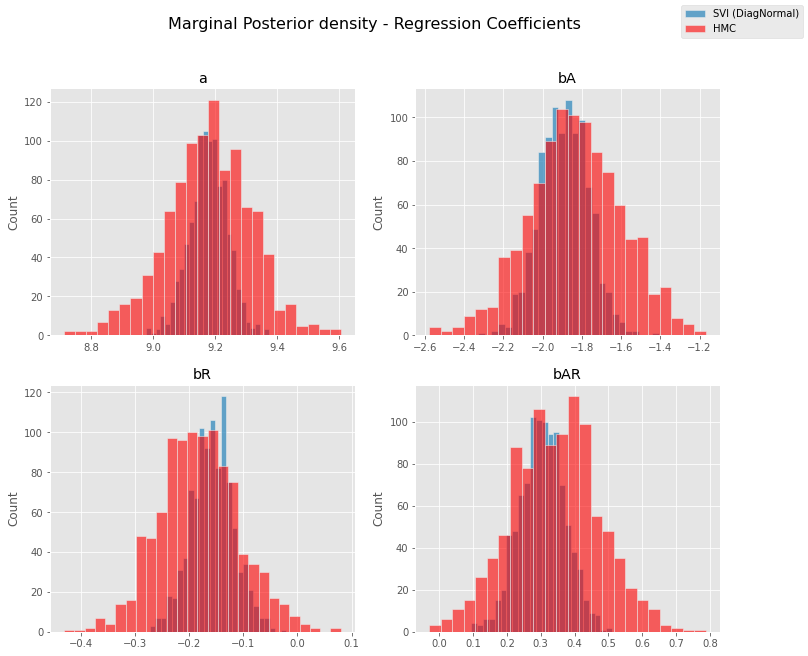

In [72]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.histplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)")
    sns.histplot(hmc_samples[site], ax=ax, color="red", alpha=0.6 ,label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

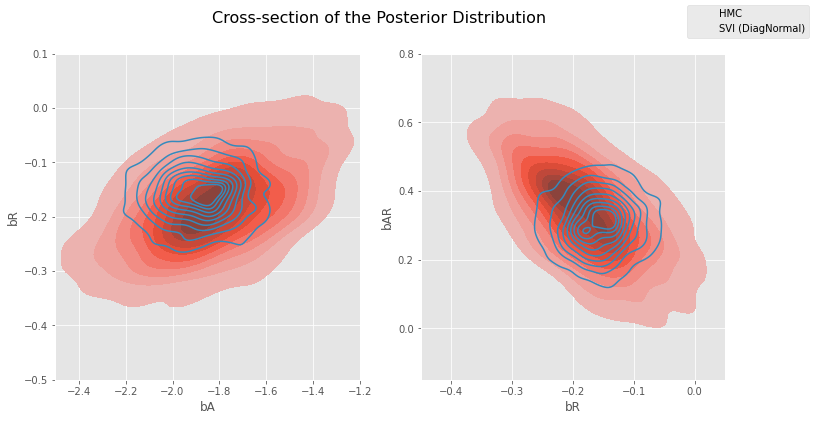

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(x=svi_samples["bA"], y=svi_samples["bR"], ax=axs[0], label="SVI (DiagNormal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(x=hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(x=svi_samples["bR"], y=svi_samples["bAR"], ax=axs[1], label="SVI (DiagNormal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

This can be better seen when we plot different cross sections from the joint posterior distribution overlaid with the approximate posterior from variational inference. Note that since our variational family has diagonal covariance, we **cannot model any correlation between the latents** and the resulting approximation is overconfident (under-dispersed)

### [MultivariateNormal Guide](http://pyro.ai/examples/bayesian_regression_ii.html#MultivariateNormal-Guide)

As comparison to the previously obtained results from Diagonal Normal guide, we will now use a guide that generates samples from a Cholesky factorization of a multivariate normal distribution. This allows us to capture the correlations between the latent variables via a covariance matrix. If we wrote this manually, we would need to combine all the latent variables so we could sample a Multivarite Normal jointly.

In [74]:
from pyro.infer.autoguide import AutoMultivariateNormal, init_to_mean

In [75]:
guide = AutoMultivariateNormal(
    model= model,
    init_loc_fn= init_to_mean
)

In [76]:
svi = SVI(
    model,
    guide,
    optim.Adam({"lr":.01}),
    loss= Trace_ELBO()
)

In [78]:
pyro.clear_param_store()
for i in range(5000):
    elbo = svi.step(is_cont_africa, ruggedness, log_gdp)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))

Elbo loss: 703.2962011098862
Elbo loss: 421.47834062576294
Elbo loss: 251.3070564866066
Elbo loss: 248.12822180986404
Elbo loss: 248.30723983049393
Elbo loss: 247.25450497865677
Elbo loss: 247.95498621463776
Elbo loss: 247.46379965543747
Elbo loss: 249.3123510479927
Elbo loss: 249.2777636051178


In [79]:
predictive = Predictive(model, guide=guide, num_samples=number_samples)

In [80]:
mvn_samples = {
    k: v.reshape(number_samples).detach().cpu().numpy() 
    for k, v in predictive(log_gdp, is_cont_africa, ruggedness).items()
    if k != "obs"
}

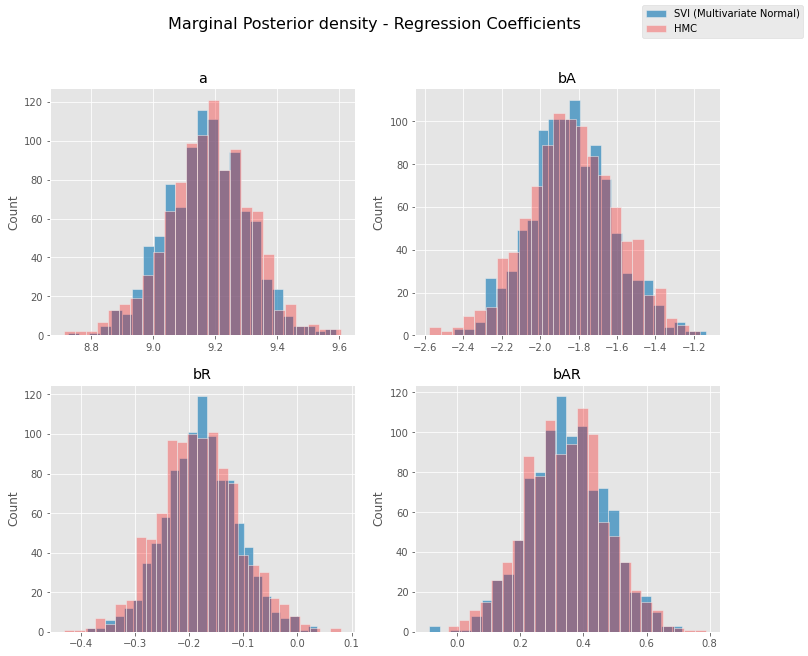

In [86]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.histplot(mvn_samples[site], ax=ax, label="SVI (Multivariate Normal)")
    sns.histplot(hmc_samples[site], ax=ax, color="red", alpha=0.3 ,label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

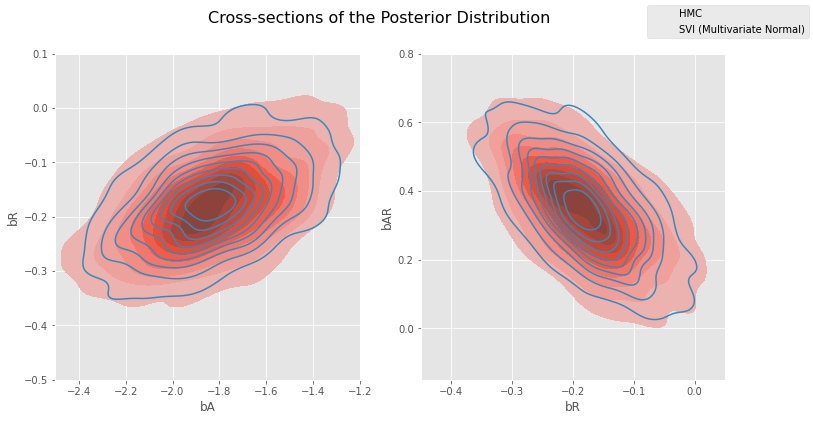

In [89]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=hmc_samples["bA"], y=hmc_samples["bR"], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(x=mvn_samples["bA"], y=mvn_samples["bR"], ax=axs[0], label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(x=hmc_samples["bR"], y=hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(x=mvn_samples["bR"], y=mvn_samples["bAR"], ax=axs[1], label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

#### Note that the Multivariate guide better captures the true posterior.